<div style="font-weight: bold; font-size: x-large; color: blue">***Setup***</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
#Returns missing values
def getMissing(df):
    totalRows = df.shape[0]

    temp = pd.DataFrame({
        "Missing": df.isnull().sum(),
        "Missing %": (df.isnull().sum() / totalRows) * 100
        
    })
    
    temp = temp[temp['Missing'] > 0]
    
    return temp.sort_values(by=['Missing'], ascending=False)  

def createHist(df, varName):    
    #Square root rule from ANA600
    numOfBins = round(np.sqrt(len(df)))

    #Histogram
    plt.figure(figsize=(10, 6))  
    plt.hist(df[varName], bins=numOfBins, color="red", alpha=0.7, edgecolor="black", density=True)
    sns.kdeplot(df[varName], color="green", label="Density")    

    #Add comma separator to X-axis
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

    #Titles and labels
    plt.title("Histogram of '" + varName + "'")
    plt.xlabel(varName)
    plt.ylabel("Frequency")
    plt.grid(True) 
    plt.legend()  # Add legend for the KDE plot
    plt.savefig(f"Graphs/Histogram - {varName}.png", dpi=300, bbox_inches='tight')
    plt.show()

def createScatterPlot(df, varX, varY):
    #Scatter plot
    plt.figure(figsize=(10, 6)) 
    sns.scatterplot(x=df[varX], y=df[varY], color="blue", alpha=0.7, edgecolor="black")

    #Add comma separator to X & Y axis
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

    #Titles and labels
    plt.title(f"Scatter Plot of '{varX}' vs '{varY}'")
    plt.xlabel(varX)
    plt.ylabel(varY)
    plt.grid(True)
    plt.savefig(f"Graphs/Scatter plot - {varY} vs {varX}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
def createBoxPlot(df, catVar, numVar):
    #Box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[catVar], y=df[numVar], palette="coolwarm", width=0.6, fliersize=5, linewidth=1.5)

    # Add comma separator to Y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

    # Titles and labels
    plt.title(f"Box Plot of '{numVar}' by '{catVar}'")
    plt.xlabel(catVar)
    plt.ylabel(numVar)
    plt.savefig(f"Graphs/Box plot - {numVar} vs {catVar}.png", dpi=300, bbox_inches='tight')
    plt.show()

def create3DScatterPlot(df, varX, varY, varZ):
    #3D graph
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    #Scatter plot for 3D visualization
    sc = ax.scatter(df[varX], df[varY], df[varZ], c=df[varZ], cmap="coolwarm", alpha=0.7, s=50)

     # Add comma separator to X, Y, and Z axis
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
    ax.zaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
    
    # Color bar
    plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10, label=varZ)
    
    #Titles and labels
    ax.set_title(f"3D Interaction of {varX}, {varZ}, and {varY}")
    ax.set_xlabel(varX)
    ax.set_ylabel(varY)
    ax.set_zlabel(varZ, labelpad=10)
    plt.savefig(f"Graphs/3D plot - {varX}, {varZ}, and {varY}.png", dpi=300, bbox_inches='tight')
    plt.show()
   


<div style="font-weight: bold; font-size: x-large; color: blue">***1. Load Data***</div>

<div style="font-weight: bold; font-size: large; color: blue">1a. Load data & filter rows:</div>

In [3]:
#Load
housing_df = pd.read_feather("Datasets/Merged.feather")

#Filter rows
housing_df = housing_df[
    (housing_df['City Name'] == 'Bakersfield') &
    #Investors prefer newer properties for lower maintenance and modern code compliance.
    (housing_df['Year Built'] >= 2000)
]

#Print
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5638 entries, 0 to 14539
Data columns (total 97 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   ML Number                            5638 non-null   int64         
 1   List Price                           5638 non-null   float64       
 2   Sold Price                           5638 non-null   float64       
 3   List Date                            5638 non-null   datetime64[ns]
 4   Sold Date                            5638 non-null   datetime64[ns]
 5   DOM                                  5638 non-null   float64       
 6   City Name                            5638 non-null   category      
 7   Zipcode                              5638 non-null   category      
 8   Area                                 5638 non-null   category      
 9   Bedrooms                             5638 non-null   float64       
 10  Bathrooms       

<div style="font-weight: bold; font-size: large; color: blue">1b. Save the original dataset (For clustering).</div>

In [4]:
#Original (For clustering)
housing_df.to_feather("Datasets/V2/Clustering/Merged V2.feather")

<div style="font-weight: bold; font-size: x-large; color: blue">***2. Missing Values***</div>

<div style="font-weight: bold; font-size: large; color: blue">2a. Identify columns with missing values.</div>

In [5]:
#Print missing values
getMissing(housing_df)

,Missing,Missing %
Sq Foot,876,15.54
Transit Score,698,12.38
Junior High School Ratings,283,5.02
Bike Score,81,1.44
Elementary School Ratings,44,0.78
High School Ratings,43,0.76
Lot Size,33,0.59
Street Number 1,5,0.09
Cross Street,2,0.04


<div style="font-weight: bold; font-size: large; color: blue">2b. Impute missing values.</div>

<div style="font-size: medium; color: green"><span style="font-weight: bold">Observations:</span> I conducted comparative analyses after imputing missing values, assessing means, medians, and correlations between the original and imputed data. The correlation between Transit Score and the outcome variable Sold Price decreased by 5.88%, while the means, medians, and correlations for the other imputed columns remained largely unchanged.</div>

In [6]:
#Vars
stats = pd.DataFrame(index=[
    #Mean
    'Mean (Original)',
    'Mean (Imputed)',
    'Percentage Difference (Mean)',

    #Median
    'Median (Original)',
    'Median (Imputed)',
    'Percentage Difference (Median)',

    #Correlation
    'Correlation (Original)',
    'Correlation (Imputed)',
    'Percentage Difference (Correlation)',
])

cols = [
    #Unique key
    'ML Number',
    
    #Add Sold Price to compute correlation
    'Sold Price',

    #Columns to impute
    'Sq Foot',
    'Transit Score',
    'Junior High School Ratings',
    'Bike Score',
    'Elementary School Ratings',
    'High School Ratings',
    'Lot Size'
]

#Impute
#I tried different numbers and 45 gave me the best results
imputer = KNNImputer(n_neighbors=45)

imputed_df = pd.DataFrame(imputer.fit_transform(housing_df[cols]), columns=housing_df[cols].columns)

#Compute statistics
for col in cols:
    #Mean
    mean_original = round(housing_df[col].mean(), 2)
    mean_imputed = round(imputed_df[col].mean(), 2)

    #Median
    median_original = round(housing_df[col].median(), 2)
    median_imputed = round(imputed_df[col].median(), 2)

    #Correlation
    corr_original = round(housing_df[col].corr(housing_df['Sold Price']), 2)
    corr_imputed = round(imputed_df[col].corr(imputed_df['Sold Price']), 2)

    stats[col] = [
         #Mean
        mean_original, 
        mean_imputed, 
        ((mean_imputed - mean_original) / mean_original * 100), 

        #Median
        median_original, 
        median_imputed,  
        ((median_imputed - median_original) / median_original * 100), 

        #Correlation
        corr_original, 
        corr_imputed,  
        ((corr_imputed - corr_original) / corr_original * 100), 
    ]

#Update the original dataset
housing_df = housing_df.set_index("ML Number")

#Overwrite=False ensures that only missing values are replaced, preserving the original values where they were not missing.
housing_df.update(imputed_df.set_index("ML Number"), overwrite=False)

#Print stats
stats.T

,Mean (Original),Mean (Imputed),Percentage Difference (Mean),Median (Original),Median (Imputed),Percentage Difference (Median),Correlation (Original),Correlation (Imputed),Percentage Difference (Correlation)
ML Number,202008926.40,202008926.40,0.00,202111817.00,202111817.00,0.00,0.03,0.03,0.00
Sold Price,435971.73,435971.73,0.00,400000.00,400000.00,0.00,1.00,1.00,0.00
Sq Foot,2121.87,2114.04,-0.37,1998.00,1986.27,-0.59,0.83,0.84,1.20
Transit Score,14.21,14.17,-0.28,17.00,17.00,0.00,-0.17,-0.16,-5.88
Junior High School Ratings,4.14,4.14,0.00,4.00,4.00,0.00,-0.11,-0.11,-0.00
Bike Score,33.68,33.68,0.00,32.00,32.00,0.00,-0.02,-0.02,-0.00
Elementary School Ratings,5.03,5.03,0.00,5.00,5.00,0.00,0.14,0.14,0.00
High School Ratings,5.74,5.74,0.00,6.00,6.00,0.00,-0.06,-0.06,-0.00
Lot Size,11733.49,11714.96,-0.16,7650.00,7649.50,-0.01,0.18,0.18,0.00


<div style="font-weight: bold; font-size: large; color: blue">2c. Check missing values again.</div>

In [7]:
#Print missing values
getMissing(housing_df)

,Missing,Missing %
Street Number 1,5,0.09
Cross Street,2,0.04


<div style="font-weight: bold; font-size: x-large; color: blue">***3. Feature Engineering & Column Filtering***</div>

<div style="font-weight: bold; font-size: large; color: blue">3a. Add new features:</div>

In [8]:
#This will prevent exponential notation in graphs and tables
housing_df['Sold Price (x100,000)'] =  (housing_df['Sold Price'] / 100000).astype('float')

#Age
housing_df['Age'] =  (housing_df['Sold Date'].dt.year - housing_df['Year Built']).astype('float')

#Month of sale
housing_df['SaleMonth'] =  housing_df['Sold Date'].dt.month.astype('float')

#Check
housing_df[[
    'Sold Price',
    'Sold Price (x100,000)',
    'Age',
    'SaleMonth', 
    'Sold Date',
    'Year Built'
]].head()

,Sold Price,"Sold Price (x100,000)",Age,SaleMonth,Sold Date,Year Built
ML Number,,,,,,
202210307,460000.00,4.60,9.00,12.00,2022-12-28,2013.00
202210311,469990.00,4.70,17.00,11.00,2022-11-04,2005.00
202210317,610000.00,6.10,4.00,10.00,2022-10-31,2018.00
202210382,399900.00,4.00,18.00,10.00,2022-10-26,2004.00
202210157,402990.00,4.03,0.00,12.00,2022-12-21,2022.00


<div style="font-weight: bold; font-size: large; color: blue">3b. Filter columns:</div>

In [9]:
#Home Value = f(
                #Sq Foot,
                #Lot Size,
                #Bedrooms,
                #Bathrooms,
                #Age of the property at the time of sale,
                #Days on Market,
                #Pool Features,
                #Zip Code, 
                #School Ratings,
                #Count of Sex Offenders in Zip Code,
                #Walk Score, 
                #Transit Score,
                #Bike Score,
                #Driving distance to nearest shopping mall,
                #Driving distance to downtown,
                #Monthly Mortgage Rate, 
                #Month of Sale
            #)
housing_filtered_df = housing_df[[    
    #Numerical
    'Sold Price (x100,000)',
    'Sold Price',
    'Sq Foot',     
    'Lot Size',  
    'Bedrooms',                       
    'Bathrooms',  
    'Age', 
    'DOM',
    'Elementary School Ratings',             
    'Junior High School Ratings',               
    'High School Ratings',           
    'Sex Offender Count',
    'Walk Score',
    'Transit Score',               
    'Bike Score',  
    'Mall Distance (Meters)',  
    'Downtown Distance (Meters)',     
    'Avg Monthly Mortgage Rate (30Y)',
    'SaleMonth',
    
    #Categorical   
    #The first 4 pool variables contain boolean values
    'Pool_Inground',                           
    'Pool_Community',                          
    'Pool_Spa',                           
    'Pool_Above_Ground',
    'Zipcode'
]]

#Print shape
housing_filtered_df.shape

(5638, 24)

In [10]:
#Print records 
housing_filtered_df.head()

,"Sold Price (x100,000)",Sold Price,Sq Foot,Lot Size,Bedrooms,Bathrooms,Age,DOM,Elementary School Ratings,Junior High School Ratings,High School Ratings,Sex Offender Count,Walk Score,Transit Score,Bike Score,Mall Distance (Meters),Downtown Distance (Meters),Avg Monthly Mortgage Rate (30Y),SaleMonth,Pool_Inground,Pool_Community,Pool_Spa,Pool_Above_Ground,Zipcode
ML Number,,,,,,,,,,,,,,,,,,,,,,,,
202210307,4.60,460000.00,1881.00,8712.00,4.00,2.00,9.00,64.00,5.00,3.00,6.00,43.00,42.00,16.00,31.00,1421.00,14708.00,6.36,12.00,0,0,0,0,93311
202210311,4.70,469990.00,2306.00,9583.00,4.00,2.00,17.00,10.00,4.00,4.00,7.00,34.00,8.00,18.00,33.00,3666.00,14991.00,6.80,11.00,0,0,0,0,93312
202210317,6.10,610000.00,2643.00,9147.00,4.00,3.00,4.00,21.00,4.00,6.00,7.00,22.00,6.00,11.56,25.00,3584.00,18873.00,6.90,10.00,0,0,0,0,93314
202210382,4.00,399900.00,1834.00,8712.00,3.00,2.00,18.00,10.00,7.00,3.00,7.00,110.00,3.00,11.00,12.00,3799.00,15393.00,6.90,10.00,0,0,0,0,93306
202210157,4.03,402990.00,1883.40,6104.00,4.00,3.00,0.00,8.00,4.00,3.00,4.00,59.00,8.00,22.00,32.00,2660.00,18091.00,6.36,12.00,0,0,0,0,93313


<div style="font-weight: bold; font-size: large; color: blue">3c. Save the original data to generate the winsorized version.</div>

In [11]:
#Split the dataset into training and test sets
#We will create 10 models using the original and winsorized datasets. Discard the test set and use the 85% training data for fair model comparison.
train, test = train_test_split(housing_filtered_df, test_size = 0.15, random_state = 1)

#Print
print(housing_filtered_df.shape)
print(train.shape)

(5638, 24)
(4792, 24)


In [12]:
#Save
train.to_feather("Datasets/V2/Prediction/Merged V2 - 85% (Original - For generating winsorized version).feather")

<div style="font-weight: bold; font-size: large; color: blue">3d. Identify numerical and categorical columns:</div>

In [13]:
#Vars
numerical_cols = []
categorical_cols = []

#Iterate and add
for c in housing_filtered_df.columns:  
    #Vars
    dtype = housing_filtered_df[c].dtype

    #Check
    if (dtype == 'float64' or dtype == 'int64'):
        numerical_cols.append(c)

    elif (dtype == 'category'):
        categorical_cols.append(c)

#Print numerical
numerical_cols

['Sold Price (x100,000)',
 'Sold Price',
 'Sq Foot',
 'Lot Size',
 'Bedrooms',
 'Bathrooms',
 'Age',
 'DOM',
 'Elementary School Ratings',
 'Junior High School Ratings',
 'High School Ratings',
 'Sex Offender Count',
 'Walk Score',
 'Transit Score',
 'Bike Score',
 'Mall Distance (Meters)',
 'Downtown Distance (Meters)',
 'Avg Monthly Mortgage Rate (30Y)',
 'SaleMonth']

In [14]:
#Print categorical
categorical_cols

['Pool_Inground', 'Pool_Community', 'Pool_Spa', 'Pool_Above_Ground', 'Zipcode']

<div style="font-weight: bold; font-size: x-large; color: blue">***4. Correlation Analysis and Data Summary***</div>

<div style="font-weight: bold; font-size: large; color: blue">4a. Compute the correlation matrix.</div>

<div style="font-size: medium; color: green"><span style="font-weight: bold">Observations:</span> The following variables have a correlation of less than 0.10 with the outcome variable: Age, DOM, High School Ratings, Bike Score, Mall Distance (Meters), and SaleMonth. The Bathrooms variable has a high correlation with Sq Foot.</div>

In [15]:
#Vars
temp = numerical_cols.copy()
temp.remove('Sold Price (x100,000)')

#Print
housing_filtered_df[temp].corr(method = 'pearson')

,Sold Price,Sq Foot,Lot Size,Bedrooms,Bathrooms,Age,DOM,Elementary School Ratings,Junior High School Ratings,High School Ratings,Sex Offender Count,Walk Score,Transit Score,Bike Score,Mall Distance (Meters),Downtown Distance (Meters),Avg Monthly Mortgage Rate (30Y),SaleMonth
Sold Price,1.00,0.84,0.18,0.39,0.66,0.01,0.07,0.14,-0.11,-0.06,-0.33,-0.17,-0.16,-0.02,0.04,0.13,0.24,0.00
Sq Foot,0.84,1.00,0.13,0.50,0.75,-0.03,0.12,0.18,-0.09,-0.03,-0.36,-0.20,-0.21,-0.04,0.05,0.14,0.00,0.00
Lot Size,0.18,0.13,1.00,0.01,0.07,0.00,0.01,0.01,0.00,-0.01,0.03,-0.04,-0.01,-0.06,0.27,0.08,0.01,-0.02
Bedrooms,0.39,0.50,0.01,1.00,0.55,-0.13,0.04,0.01,-0.08,-0.00,-0.17,-0.07,-0.06,-0.04,-0.06,0.13,0.02,0.00
Bathrooms,0.66,0.75,0.07,0.55,1.00,-0.13,0.08,0.12,-0.07,-0.04,-0.21,-0.16,-0.13,-0.07,0.05,0.13,0.05,0.00
Age,0.01,-0.03,0.00,-0.13,-0.13,1.00,-0.04,0.10,0.04,0.14,-0.06,0.35,0.17,0.28,-0.21,-0.28,0.05,-0.02
DOM,0.07,0.12,0.01,0.04,0.08,-0.04,1.00,0.03,-0.01,-0.02,-0.01,-0.04,-0.06,-0.01,0.03,0.02,0.14,0.06
Elementary School Ratings,0.14,0.18,0.01,0.01,0.12,0.10,0.03,1.00,-0.04,-0.04,-0.22,-0.02,-0.21,0.13,-0.02,0.08,0.03,0.00
Junior High School Ratings,-0.11,-0.09,0.00,-0.08,-0.07,0.04,-0.01,-0.04,1.00,0.49,0.28,-0.02,0.05,-0.18,0.26,-0.16,-0.01,0.01
High School Ratings,-0.06,-0.03,-0.01,-0.00,-0.04,0.14,-0.02,-0.04,0.49,1.00,-0.06,0.07,-0.15,-0.09,0.07,-0.15,0.01,-0.01


<div style="font-weight: bold; font-size: large; color: blue">4b. Drop columns with low correlation to the outcome variable and high multicollinearity.</div>

<div style="font-size: medium; color: green"><span style="font-weight: bold">Comments:</span> Even though some of the variables I retained have a weak correlation with the outcome variable, they help create useful interactions that may have a stronger correlation with the outcome variable. Additionally, the Recursive Feature Elimination (RFE) technique will remove them if they are not found to be useful.</div>

In [16]:
#Following variables have a correlation of less than 0.10 with the outcome variable
numerical_cols.remove('Age')
numerical_cols.remove('DOM')
numerical_cols.remove('High School Ratings')
numerical_cols.remove('Bike Score')
numerical_cols.remove('Mall Distance (Meters)')
numerical_cols.remove('SaleMonth')

#Following variable has a high correlation with Sq Foot
numerical_cols.remove('Bathrooms')

#Drop columns
housing_filtered_df.drop(columns=[
    'Age',
    'DOM',
    'High School Ratings',
    'Bike Score',
    'Mall Distance (Meters)',
    'SaleMonth',
    'Bathrooms'
], inplace=True)

<div style="font-weight: bold; font-size: large; color: blue">4c. Generate descriptive stats.</div>

<div style="font-size: medium; color: green"><span style="font-weight: bold">Observations:</span> Some columns have outliers, and I verified a few random values on Zillow, confirming they are not data entry errors.</div>

In [17]:
#Vars
percentiles = np.concatenate((np.array([0.01, 0.02, 0.03, 0.04, 0.96, 0.97, 0.98, 0.99]), np.arange(0.05, 1.0, 0.05)))

temp = numerical_cols.copy()
temp.remove('Sold Price')

#Print
housing_filtered_df[temp].describe(percentiles = percentiles)        

,"Sold Price (x100,000)",Sq Foot,Lot Size,Bedrooms,Elementary School Ratings,Junior High School Ratings,Sex Offender Count,Walk Score,Transit Score,Downtown Distance (Meters),Avg Monthly Mortgage Rate (30Y)
count,5638.00,5638.00,5638.00,5638.00,5638.00,5638.00,5638.00,5638.00,5638.00,5638.00,5638.00
mean,4.36,2114.04,11714.96,3.66,5.03,4.14,65.54,15.29,14.17,15198.23,4.54
std,1.82,677.08,73887.49,0.76,1.69,1.53,49.99,14.02,10.35,4732.62,1.74
min,1.25,816.00,0.14,0.00,2.00,2.00,0.00,0.00,0.00,1942.00,2.68
1%,2.23,1116.00,2178.00,2.00,2.00,2.00,22.00,0.00,0.00,6232.92,2.68
2%,2.40,1174.00,3920.00,2.00,2.00,2.00,22.00,0.00,0.00,7491.74,2.68
3%,2.46,1247.11,4500.00,2.00,2.00,2.00,22.00,0.00,0.00,7841.00,2.68
4%,2.55,1273.00,4791.00,2.00,2.00,2.00,22.00,0.00,0.00,8072.00,2.77
5%,2.60,1314.70,4792.00,3.00,3.00,2.00,22.00,0.00,0.00,8339.35,2.77
10%,2.87,1433.70,6010.10,3.00,3.00,2.00,22.00,1.00,0.00,10423.70,2.84


<div style="font-weight: bold; font-size: large; color: blue">4d. Compute absolute skewness.</div>

<div style="font-size: medium; color: green"><span style="font-weight: bold">Observations:</span> 'Lot Size' and 'Downtown Distance (Meters)' variables have an absolute skewness greater than 5.</div>

In [18]:
#Vars
temp = numerical_cols.copy()
temp.remove('Sold Price (x100,000)')

#Print
housing_filtered_df[temp].apply(lambda x: abs(skew(x, nan_policy = 'raise'))).sort_values(ascending = False)

Lot Size                          51.28
Downtown Distance (Meters)        16.79
Sold Price                         4.03
Sq Foot                            2.59
Sex Offender Count                 1.40
Walk Score                         1.29
Avg Monthly Mortgage Rate (30Y)    0.41
Junior High School Ratings         0.37
Elementary School Ratings          0.29
Bedrooms                           0.19
Transit Score                      0.11
dtype: float64

<div style="font-weight: bold; font-size: x-large; color: blue">***5. Combine Sparse Categories***</div>

<div style="font-weight: bold; font-size: large; color: blue">5a. Display the count of records in each category.</div>

In [19]:
#Filtering records after creating categorical columns retains unused categories, which may appear with a count of 0 in value_counts(). Following code will fix it.
housing_filtered_df["Zipcode"] = housing_filtered_df["Zipcode"].astype(str).astype("category")

housing_filtered_df["Pool_Inground"] = housing_filtered_df["Pool_Inground"].astype(str).astype("category")
housing_filtered_df["Pool_Community"] = housing_filtered_df["Pool_Community"].astype(str).astype("category")
housing_filtered_df["Pool_Spa"] = housing_filtered_df["Pool_Spa"].astype(str).astype("category")
housing_filtered_df["Pool_Above_Ground"] = housing_filtered_df["Pool_Above_Ground"].astype(str).astype("category")

#Print
for c in categorical_cols: 
    print(housing_filtered_df[c].value_counts())
    print('\n')

Pool_Inground
0    4289
1    1349
Name: count, dtype: int64


Pool_Community
0    5066
1     572
Name: count, dtype: int64


Pool_Spa
0    5251
1     387
Name: count, dtype: int64


Pool_Above_Ground
0    5603
1      35
Name: count, dtype: int64


Zipcode
93312    1206
93311    1188
93314     928
93313     903
93306     549
93307     481
93308     350
93304      12
93301      11
93309       6
93305       3
93303       1
Name: count, dtype: int64




<div style="font-weight: bold; font-size: large; color: blue">5b. Combine sparse ZIP codes.</div>

In [20]:
#Merge the following zip codes due to sparsity and geographic proximity. 
temp = ["93304", "93301", "93309", "93305"]

#Categorize the above listed zip codes as 'Other'
housing_filtered_df["Zipcode"] = housing_filtered_df["Zipcode"].replace(temp, "Other")

#Remove ZIP code 93303 as it’s outside the town with only one house.
housing_filtered_df = housing_filtered_df[housing_filtered_df["Zipcode"] != "93303"]

#Filtering records after creating categorical columns retains unused categories, which may appear with a count of 0 in value_counts(). Following code will fix it.
housing_filtered_df["Zipcode"] = housing_filtered_df["Zipcode"].astype(str).astype("category")

#Print
housing_filtered_df['Zipcode'].value_counts()

Zipcode
93312    1206
93311    1188
93314     928
93313     903
93306     549
93307     481
93308     350
Other      32
Name: count, dtype: int64

<div style="font-weight: bold; font-size: large; color: blue">5c. Remove specific pool features.</div>

In [21]:
#Remove Pool_Above_Ground because it has very low counts of 1,
#which might not contribute much to the model and could even lead to instability in estimates due to class imbalance.
housing_filtered_df = housing_filtered_df.drop(columns=['Pool_Above_Ground'])

<div style="font-weight: bold; font-size: large; color: blue">5d. Detect redundant categories by examining the target variable's mean.</div>

<mark style="font-size: medium;">This method is less reliable because the categorical variables involved have class imbalance, which can distort the mean or median, reducing its effectiveness in identifying redundant categories.</mark>

<div style="font-size: medium; color: green"><span style="font-weight: bold">Observations:</span> I didn't find any redundant categories.</div>

In [22]:
#Vars
temp = housing_filtered_df[["Sold Price", "Zipcode", "Pool_Inground", "Pool_Community", "Pool_Spa"]].dropna()

#Print
temp.groupby("Zipcode")["Sold Price"].mean().sort_values()

Zipcode
Other   312699.69
93307   313413.55
93306   370580.23
93308   373652.32
93313   375484.21
93312   443348.04
93311   483312.86
93314   554830.56
Name: Sold Price, dtype: float64

In [23]:
#Print
temp.groupby("Pool_Inground")["Sold Price"].mean().sort_values()

Pool_Inground
0   392657.29
1   573809.60
Name: Sold Price, dtype: float64

In [24]:
#Print
temp.groupby("Pool_Community")["Sold Price"].mean().sort_values()

Pool_Community
1   418732.77
0   437960.21
Name: Sold Price, dtype: float64

In [25]:
#Print
temp.groupby("Pool_Spa")["Sold Price"].mean().sort_values()

Pool_Spa
0   421689.30
1   630270.67
Name: Sold Price, dtype: float64

<div style="font-weight: bold; font-size: x-large; color: blue">***6. Interaction Terms***</div>

<div style="font-weight: bold; font-size: large; color: blue">6a. Create two-way interaction terms between numerical variables.</div>

In [26]:
#Create entity set
es = ft.EntitySet(id = 'housing_data')

#Skip logical_types parameter as all variables involved are numerical
es = es.add_dataframe(
    dataframe_name="Housing Data",
    dataframe=housing_filtered_df[numerical_cols],
    index=housing_filtered_df.index.name
)

#Run deep feature synthesis
feature_matrix, feature_defs = ft.dfs(
    entityset = es,
    target_dataframe_name = 'Housing Data',
    trans_primitives = ['multiply_numeric'],
    ignore_columns   = {
        'Housing Data': ['Sold Price (x100,000)']
    },
    drop_contains = ['Sold Price *', '* Sold Price'],
    max_depth=2
)

#Print columns
feature_matrix.columns

Index(['Sold Price', 'Sq Foot', 'Lot Size', 'Bedrooms',
       'Elementary School Ratings', 'Junior High School Ratings',
       'Sex Offender Count', 'Walk Score', 'Transit Score',
       'Downtown Distance (Meters)', 'Avg Monthly Mortgage Rate (30Y)',
       'Avg Monthly Mortgage Rate (30Y) * Bedrooms',
       'Avg Monthly Mortgage Rate (30Y) * Downtown Distance (Meters)',
       'Avg Monthly Mortgage Rate (30Y) * Elementary School Ratings',
       'Avg Monthly Mortgage Rate (30Y) * Junior High School Ratings',
       'Avg Monthly Mortgage Rate (30Y) * Lot Size',
       'Avg Monthly Mortgage Rate (30Y) * Sex Offender Count',
       'Avg Monthly Mortgage Rate (30Y) * Sq Foot',
       'Avg Monthly Mortgage Rate (30Y) * Transit Score',
       'Avg Monthly Mortgage Rate (30Y) * Walk Score',
       'Bedrooms * Downtown Distance (Meters)',
       'Bedrooms * Elementary School Ratings',
       'Bedrooms * Junior High School Ratings', 'Bedrooms * Lot Size',
       'Bedrooms * Sex Offender Co

<div style="font-weight: bold; font-size: large; color: blue">6b. Identify low-VIF (Less than 5) interaction terms using a stepwise approach.</div>

<div style="font-size: medium; color: green"><span style="font-weight: bold">Observations:</span> The only interaction terms with low VIF are 'Lot Size x Walk Score' and 'Sex Offender Count x Walk Score'.</div>

In [27]:
#Vars
#Drop outcome variable ('Sold Price') 
X = feature_matrix[[
    #Main terms
    'Sq Foot',
    'Lot Size',
    'Bedrooms',
    'Elementary School Ratings',
    'Junior High School Ratings',
    'Sex Offender Count',
    'Walk Score',
    'Transit Score',
    'Downtown Distance (Meters)',
    'Avg Monthly Mortgage Rate (30Y)',

    #Interaction terms
    #'Avg Monthly Mortgage Rate (30Y) * Bedrooms',
    #'Avg Monthly Mortgage Rate (30Y) * Downtown Distance (Meters)',
    #'Avg Monthly Mortgage Rate (30Y) * Elementary School Ratings',
    #'Avg Monthly Mortgage Rate (30Y) * Junior High School Ratings',
    #'Avg Monthly Mortgage Rate (30Y) * Lot Size',
    #'Avg Monthly Mortgage Rate (30Y) * Sex Offender Count',
    #'Avg Monthly Mortgage Rate (30Y) * Sq Foot',
    #'Avg Monthly Mortgage Rate (30Y) * Transit Score',
    #'Avg Monthly Mortgage Rate (30Y) * Walk Score',
    #'Bedrooms * Downtown Distance (Meters)',
    #'Bedrooms * Elementary School Ratings',
    #'Bedrooms * Junior High School Ratings',
    #'Bedrooms * Lot Size',
    #'Bedrooms * Sex Offender Count',
    #'Bedrooms * Sq Foot',
    #'Bedrooms * Transit Score',
    #'Bedrooms * Walk Score',
    #'Downtown Distance (Meters) * Elementary School Ratings',
    #'Downtown Distance (Meters) * Junior High School Ratings',
    #'Downtown Distance (Meters) * Lot Size',
    #'Downtown Distance (Meters) * Sex Offender Count',
    #'Downtown Distance (Meters) * Sq Foot',
    #'Downtown Distance (Meters) * Transit Score',
    ##'Downtown Distance (Meters) * Walk Score',
    #'Elementary School Ratings * Junior High School Ratings',
    #'Elementary School Ratings * Lot Size',
    #'Elementary School Ratings * Sex Offender Count',
    #'Elementary School Ratings * Sq Foot',
    #'Elementary School Ratings * Transit Score',
    #'Elementary School Ratings * Walk Score',
    #'Junior High School Ratings * Lot Size',
    #'Junior High School Ratings * Sex Offender Count',
    #'Junior High School Ratings * Sq Foot',
    ##'Junior High School Ratings * Transit Score',
    ##'Junior High School Ratings * Walk Score',
    #'Lot Size * Sex Offender Count',
    #'Lot Size * Sq Foot',
    #'Lot Size * Transit Score',
    'Lot Size * Walk Score',
    #'Sex Offender Count * Sq Foot',
    #'Sex Offender Count * Transit Score',
    'Sex Offender Count * Walk Score',
    #'Sq Foot * Transit Score',
    #'Sq Foot * Walk Score',
    ##'Transit Score * Walk Score'
]]

#Add intercept for VIF calculation
X.insert(0, 'Intercept', 1)

#Compute VIF for the independent variables
vif = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

#Print VIF values
#A high VIF (>5) indicates multicollinearity
vif.sort_values(by='VIF', ascending=False)

,Feature,VIF
0,Intercept,78.07
12,Sex Offender Count * Walk Score,5.00
7,Walk Score,4.29
6,Sex Offender Count,3.04
1,Sq Foot,1.66
8,Transit Score,1.56
11,Lot Size * Walk Score,1.54
3,Bedrooms,1.37
9,Downtown Distance (Meters),1.27
4,Elementary School Ratings,1.13


<div style="font-weight: bold; font-size: large; color: blue">6c. Generate a correlation matrix for the chosen interaction terms.</div>

<div style="font-size: medium; color: green"><span style="font-weight: bold">Observations:</span> The only interaction term with a correlation greater than 0.10 to the outcome variable is 'Sex Offender Count x Walk Score'.</div>

In [28]:
#Print
feature_matrix[[
    'Sold Price',
    'Sex Offender Count * Walk Score',
    'Lot Size * Walk Score'
]].corr(method = 'pearson')

,Sold Price,Sex Offender Count * Walk Score,Lot Size * Walk Score
Sold Price,1.00,-0.28,0.09
Sex Offender Count * Walk Score,-0.28,1.00,0.32
Lot Size * Walk Score,0.09,0.32,1.00


<div style="font-weight: bold; font-size: large; color: blue">6d. Incorporate interaction terms into the main dataset.</div>

In [29]:
housing_filtered_df['Sex Offender Count * Walk Score'] =  (housing_filtered_df['Sex Offender Count'] * housing_filtered_df['Walk Score']).astype('float')

#Print
housing_filtered_df[[
    'Sex Offender Count',
    'Walk Score',
    'Sex Offender Count * Walk Score'
]].head()

,Sex Offender Count,Walk Score,Sex Offender Count * Walk Score
ML Number,,,
202210307,43.00,42.00,1806.00
202210311,34.00,8.00,272.00
202210317,22.00,6.00,132.00
202210382,110.00,3.00,330.00
202210157,59.00,8.00,472.00


<div style="font-weight: bold; font-size: x-large; color: blue">***7. Save Dataset***</div>

<div style="font-weight: bold; font-size: large; color: blue">7a. Save the filtered dataset.</div>

In [30]:
#Split the dataset into training and test sets
train, test = train_test_split(housing_filtered_df, test_size = 0.15, random_state = 1)

#Print
print(housing_filtered_df.shape)
print(train.shape)
print(test.shape)

(5637, 17)
(4791, 17)
(846, 17)


In [31]:
#Filtered (For predictive modeling)
train.to_feather("Datasets/V2/Prediction/Merged V2 - 85% (Original - For training models).feather")
test.to_feather("Datasets/V2/Prediction/Merged V2 - 15% (Original - For testing models).feather")

#Save sample
housing_filtered_df.head(200).to_csv("Temp/Merged_Sample_V2 (For prediction).csv")

<div style="font-weight: bold; font-size: x-large; color: blue">***8. Univariate Graphs (For the Presentation)***</div>

<div style="font-weight: bold; font-size: large; color: blue">8a. Histogram for 'Lot Size'.</div>

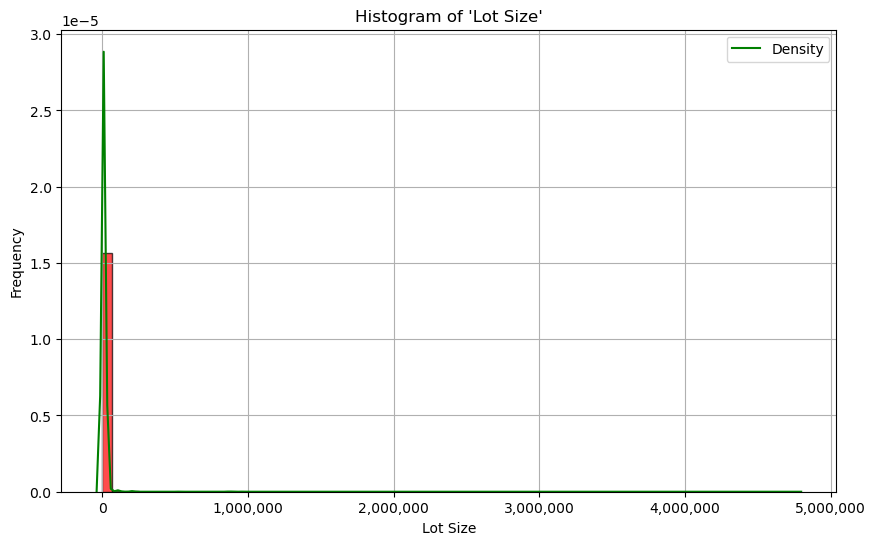

In [32]:
createHist(housing_filtered_df, 'Lot Size')

<div style="font-weight: bold; font-size: large; color: blue">8b. Histogram for 'Downtown Distance (Meters)'.</div>

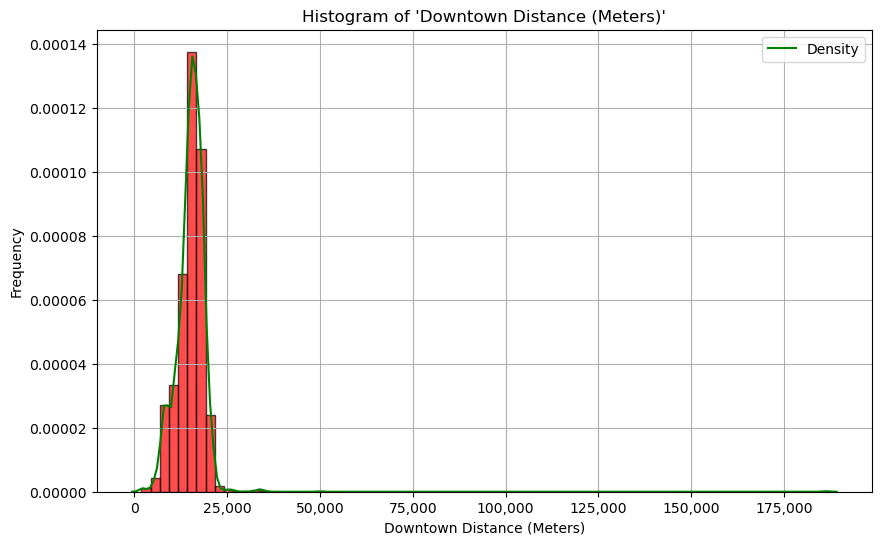

In [33]:
createHist(housing_filtered_df, 'Downtown Distance (Meters)')

<div style="font-weight: bold; font-size: x-large; color: blue">***9. Bivariate Graphs (For the Presentation)***</div>

<div style="font-weight: bold; font-size: large; color: blue">9a. Scatter Plot for 'Sold Price' & 'Sq Foot'.</div>

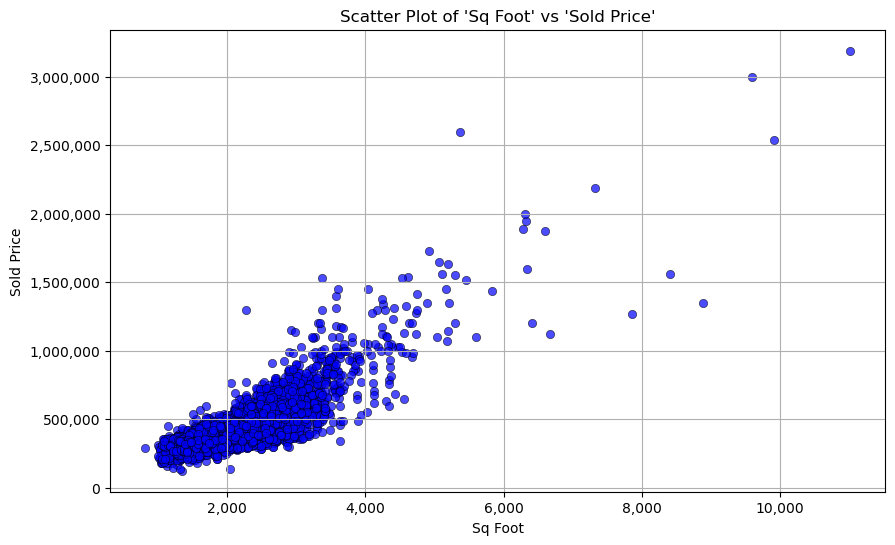

In [34]:
createScatterPlot(housing_filtered_df, 'Sq Foot', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9b. Scatter Plot for 'Sold Price' & 'Lot Size'.</div>

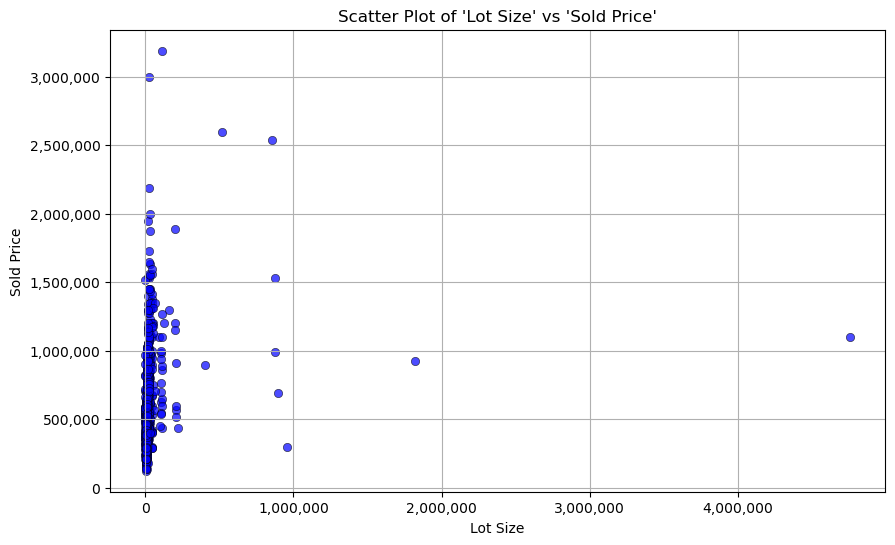

In [35]:
createScatterPlot(housing_filtered_df, 'Lot Size', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9c. Scatter Plot for 'Sold Price' & 'Bedrooms'.</div>

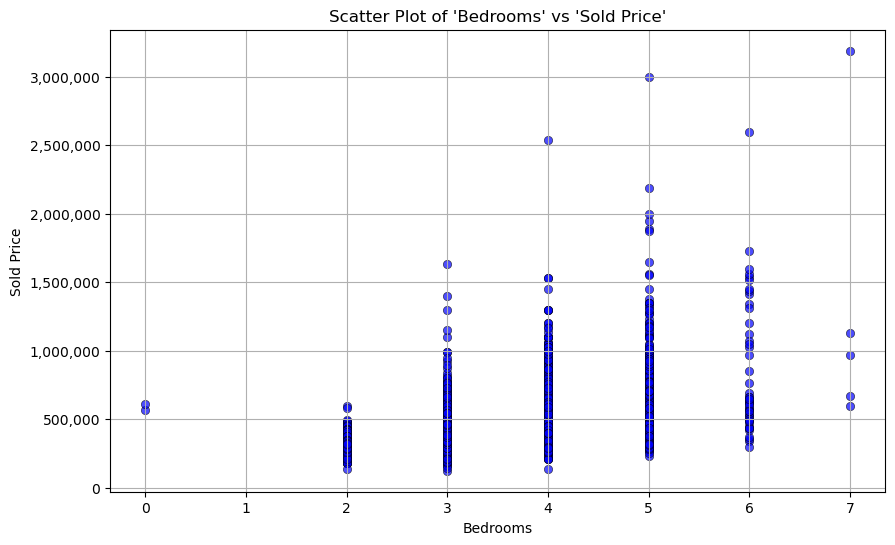

In [36]:
createScatterPlot(housing_filtered_df, 'Bedrooms', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9d. Scatter Plot for 'Sold Price' & 'Elementary School Ratings'.</div>

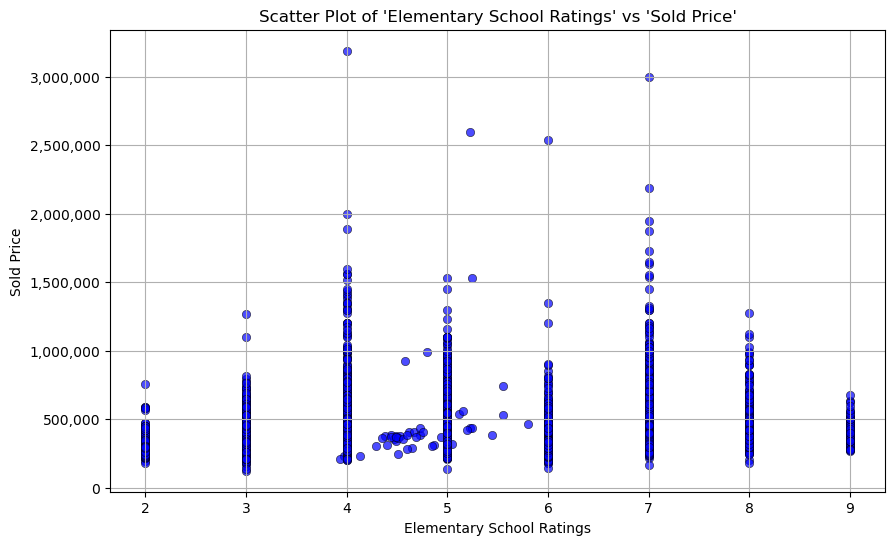

In [37]:
createScatterPlot(housing_filtered_df, 'Elementary School Ratings', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9e. Scatter Plot for 'Sold Price' & 'Junior High School Ratings'.</div>

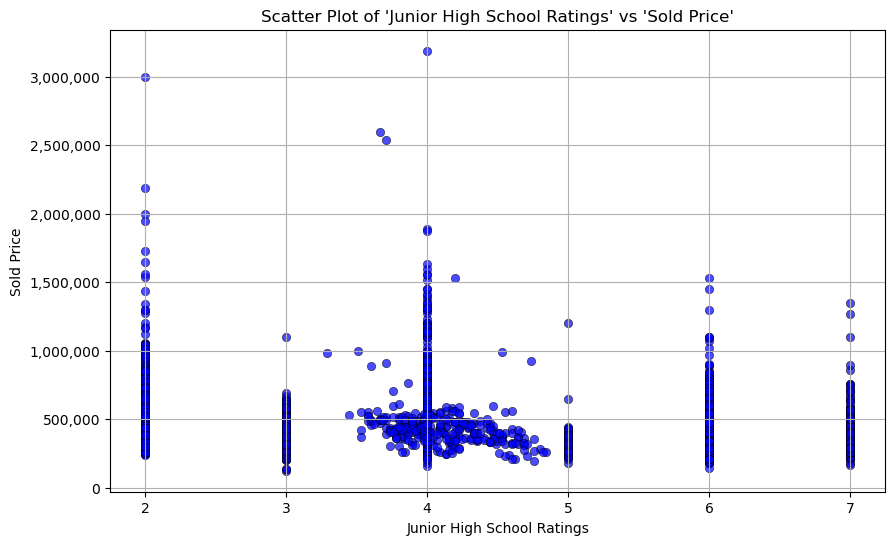

In [38]:
createScatterPlot(housing_filtered_df, 'Junior High School Ratings', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9f. Scatter Plot for 'Sold Price' & 'Sex Offender Count'.</div>

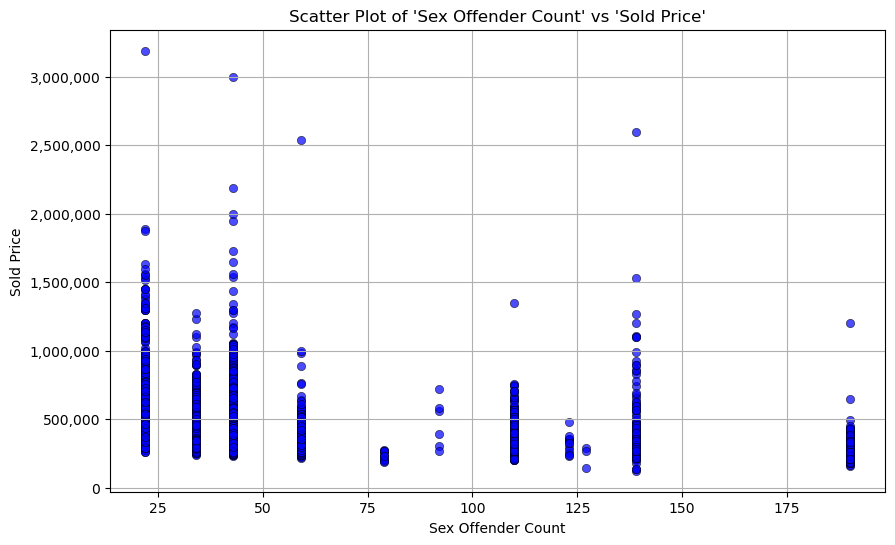

In [39]:
createScatterPlot(housing_filtered_df, 'Sex Offender Count', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9g. Scatter Plot for 'Sold Price' & 'Walk Score'.</div>

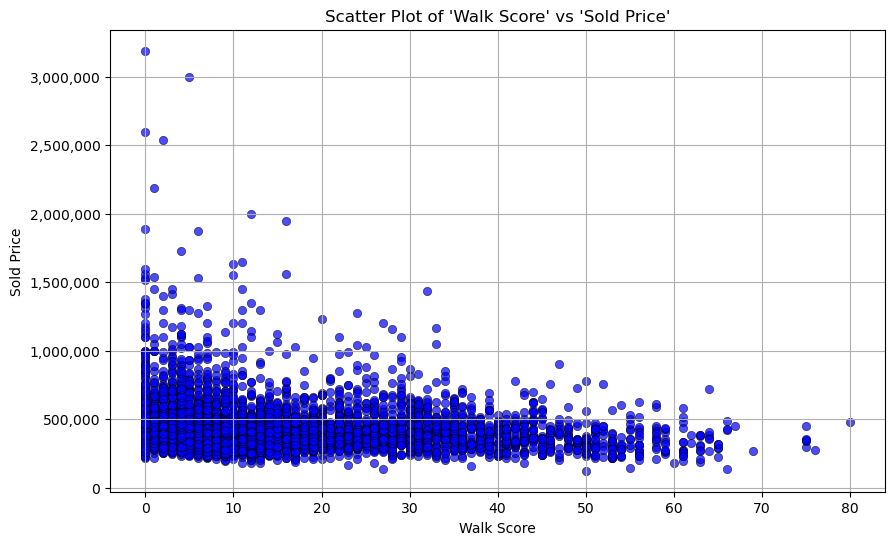

In [40]:
createScatterPlot(housing_filtered_df, 'Walk Score', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9h. Scatter Plot for 'Sold Price' & 'Transit Score'.</div>

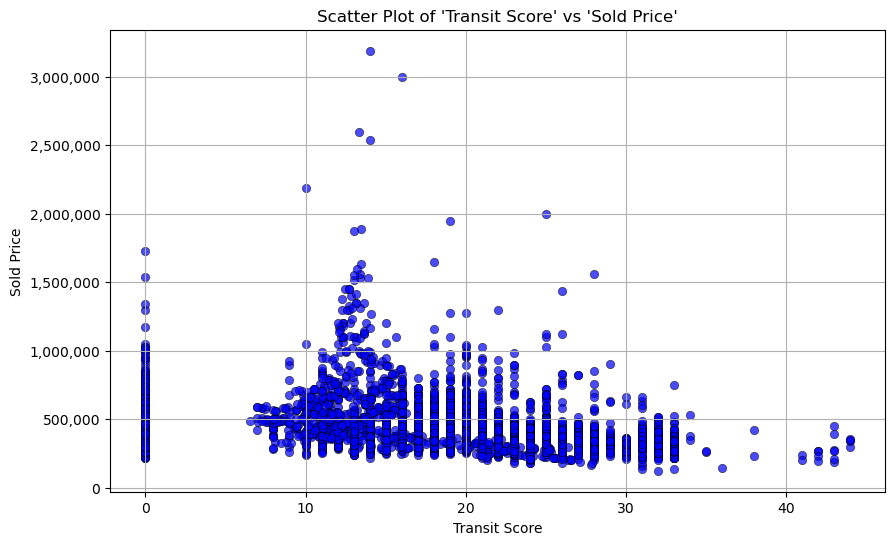

In [41]:
createScatterPlot(housing_filtered_df, 'Transit Score', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9i. Scatter Plot for 'Sold Price' & 'Downtown Distance (Meters)'.</div>

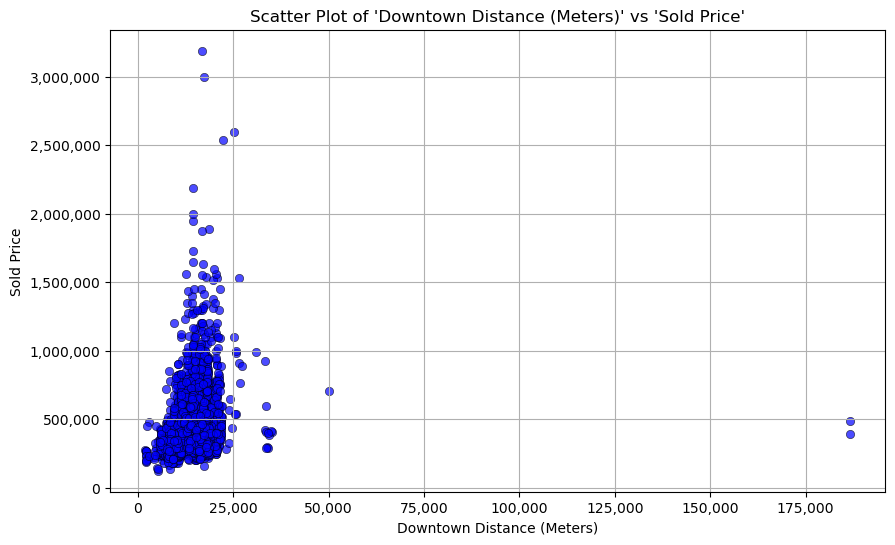

In [42]:
createScatterPlot(housing_filtered_df, 'Downtown Distance (Meters)', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9j. Scatter Plot for 'Sold Price' & 'Avg Monthly Mortgage Rate (30Y)'.</div>

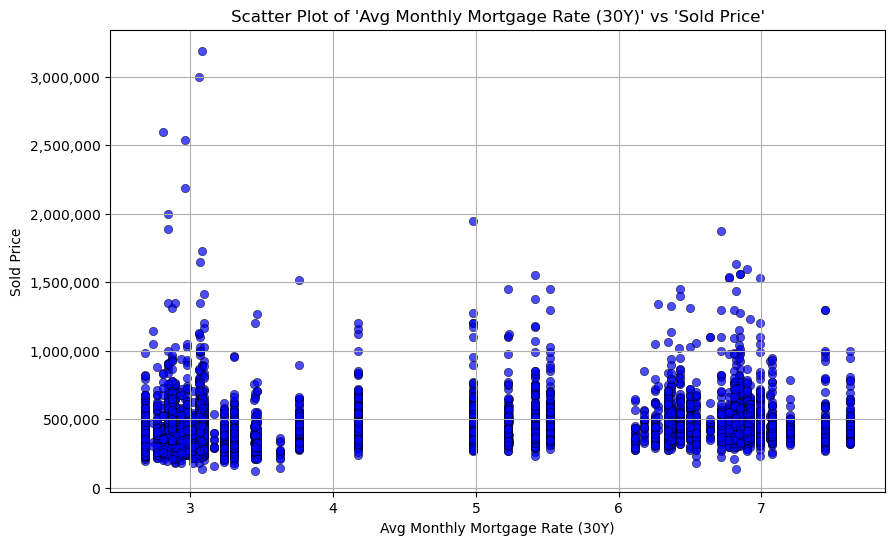

In [43]:
createScatterPlot(housing_filtered_df, 'Avg Monthly Mortgage Rate (30Y)', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9k. Box Plot for 'Sold Price' & 'Zipcode'.</div>

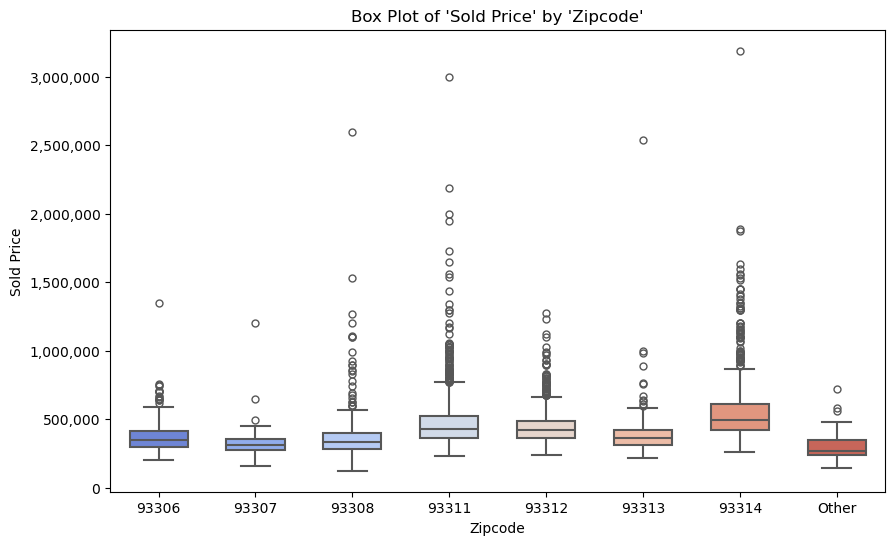

In [44]:
createBoxPlot(housing_filtered_df, 'Zipcode', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9l. Box Plot for 'Sold Price' & 'Pool_Inground'.</div>

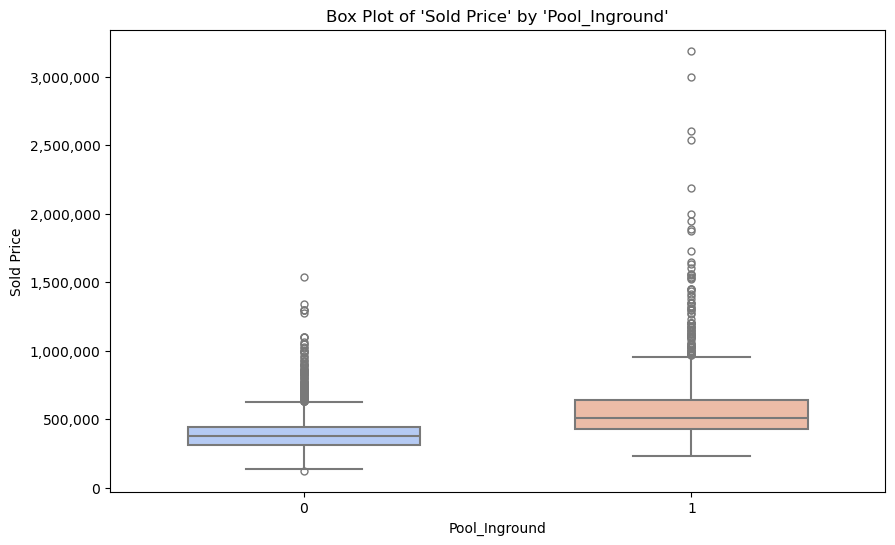

In [45]:
createBoxPlot(housing_filtered_df, 'Pool_Inground', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9m. Box Plot for 'Sold Price' & 'Pool_Community'.</div>

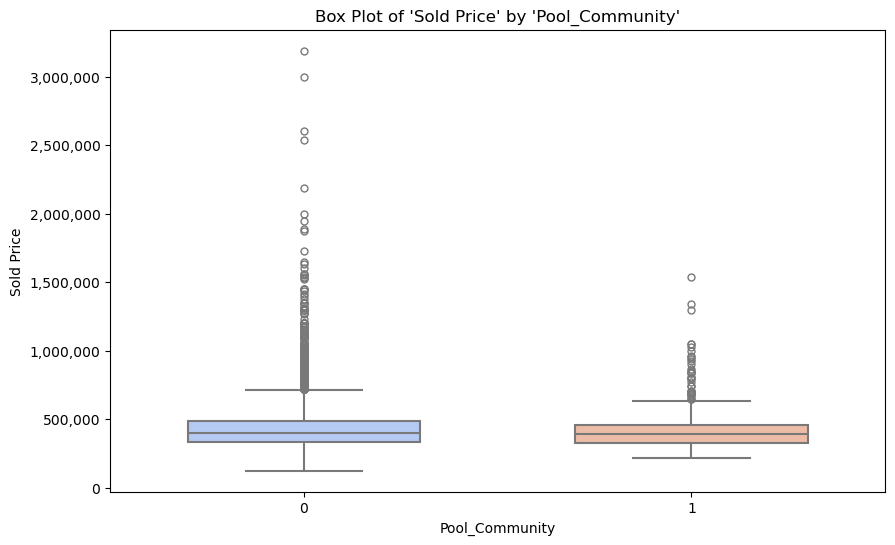

In [46]:
createBoxPlot(housing_filtered_df, 'Pool_Community', 'Sold Price')

<div style="font-weight: bold; font-size: large; color: blue">9n. Box Plot for 'Sold Price' & 'Pool_Spa'.</div>

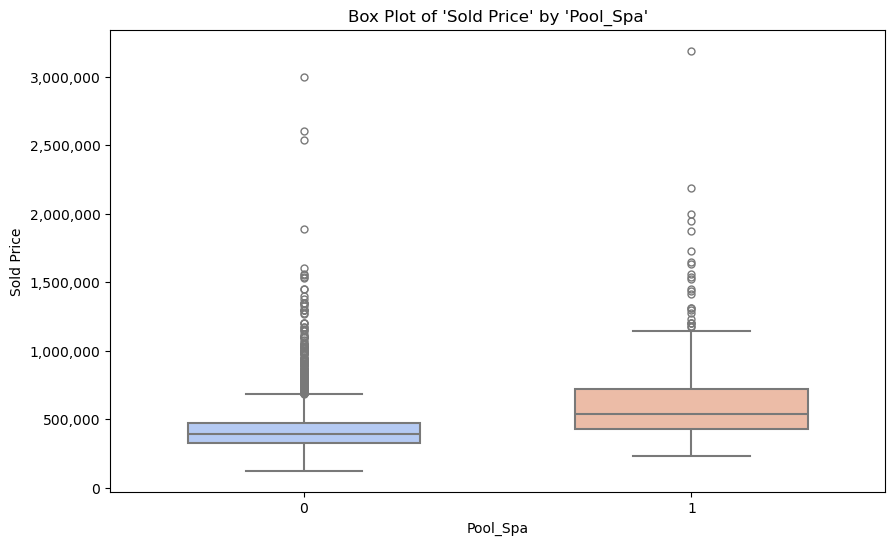

In [47]:
createBoxPlot(housing_filtered_df, 'Pool_Spa', 'Sold Price')

<div style="font-weight: bold; font-size: x-large; color: blue">***10. Multivariate Graphs (For the Presentation)***</div>

<div style="font-weight: bold; font-size: large; color: blue">10a. 3D Plot for 'Walk Score', 'Sex Offender Count', and 'Sold Price'.</div>

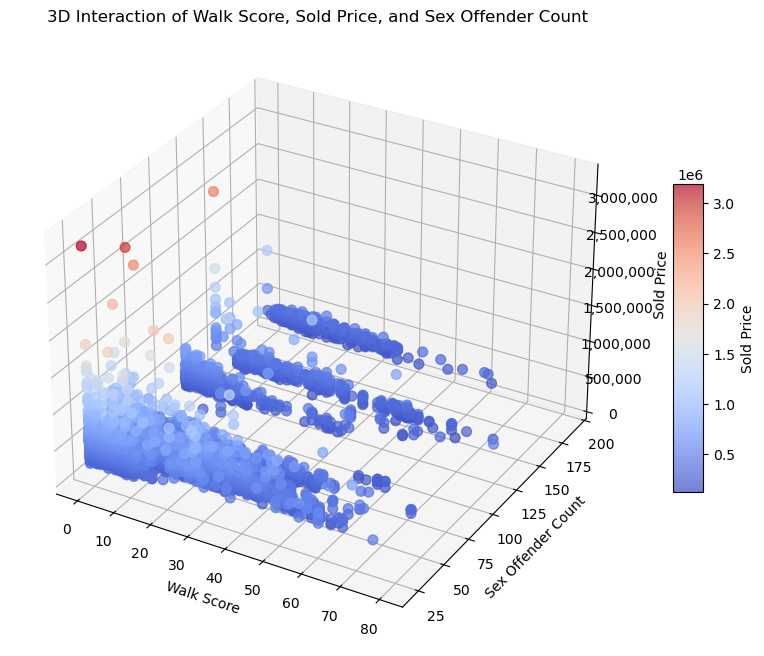

In [48]:
create3DScatterPlot(housing_filtered_df, 'Walk Score', 'Sex Offender Count', 'Sold Price')